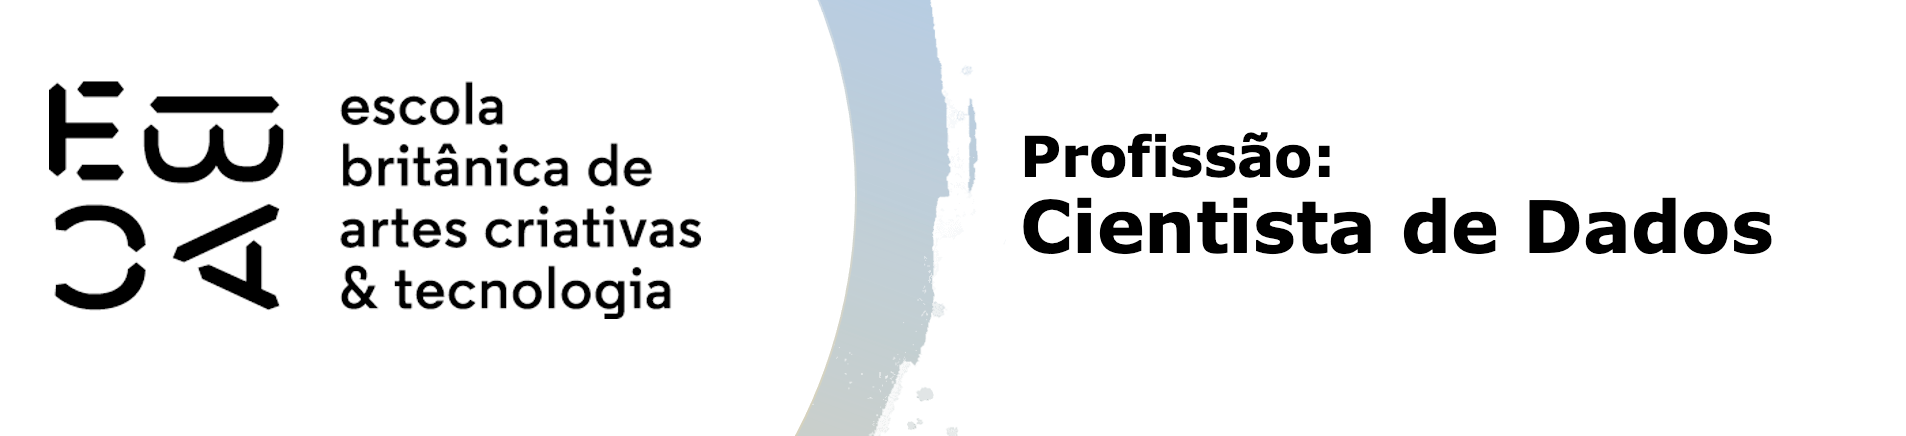

# Tarefa II

Ainda sobre a base da NFP vista na tarefa passada:

|Campo|Descrição|
|:-|:-|
|CNPJ emit.| CNPJ do emitente da nota|
|Emitente| Nome fantasia do emitente da nota|
|No.| Número da nota fiscal|
|Data Emissão| Data de emissão da nota fiscal|
|Valor NF| Valor da nota fiscal|
|Data Registro| Data de registro no sistema da NFP|
|Créditos| Valor dos créditos (doação)|
|Situação do Crédito| Se o crédito já foi pago, está sendo processado etc.|
|Ano| Ano da emissão da nota|
|Semestre| Semestre da emissão da nota|
|Retorno| Valor do crédito dividido pelo valor da nota|
|flag_credito| Indicadora se a nota possui crédito positivo|
|categoria| Categorização da nota |

**OBJETIVO:** Algumas notas não dão retorno, o que pode ocorrer por diversos motivos, um deles seria a ocorrência de produtos não incentivados como cigarros e bebidas alcólicas. O nosso objetivo é tentar prever que tipo de nota tem maior ou menor propensão a fornecer créditos.

**Observação**: Esta é uma base real, havendo características de acordo. Pode haver uma variabilidade difícil de explicar, em parte por causa de uma freqüência de notas inconstante no tempo (por diversos motivos), em parte por haverem informações importantes, protegidas pela LGPD, não constantes na base, que pode interferir no crédito gerado, o que vai ocasionar uma variabilidade difícil de se explicar. *Welcome to the jungle*, A vida real é assim :)

**Utilizaremos o mesmo arquivo csv da atividade anterior, porém já com as devidas limpezas**

In [36]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


In [37]:
df = pd.read_csv('renda_clean.csv')

In [38]:
df.head()

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria
0,03.476.811/0741-98,DIA BRASIL SOCIEDADE LIMITADA,537,2017-06-30,24.68,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Mercado
1,43.101.310/0001-05,AUTO POSTO ZANWAL LTDA EPP,2894,2017-06-30,50.00,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Auto posto
2,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,699,2017-06-30,27.00,2017-06-30,0.44,Liberado,2017,1,0.016296,1,Restaurantes
3,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,698,2017-06-30,111.50,2017-06-30,1.81,Liberado,2017,1,0.016233,1,Restaurantes
4,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,694,2017-06-30,125.00,2017-06-30,2.03,Liberado,2017,1,0.016240,1,Restaurantes


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186666 entries, 0 to 186665
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   CNPJ emit.           186666 non-null  object 
 1   Emitente             186666 non-null  object 
 2   No.                  186666 non-null  int64  
 3   Data Emissão         186666 non-null  object 
 4   Valor NF             186666 non-null  float64
 5   Data Registro        186666 non-null  object 
 6   Créditos             186666 non-null  float64
 7   Situação do Crédito  186666 non-null  object 
 8   Ano                  186666 non-null  int64  
 9   Semestre             186666 non-null  int64  
 10  Retorno              186666 non-null  float64
 11  flag_credito         186666 non-null  int64  
 12  categoria            186666 non-null  object 
dtypes: float64(3), int64(4), object(6)
memory usage: 18.5+ MB


## Criando variáveis

**Variáveis temporais**: É possível que haja alguma regra de liberação de créditos de acordo com o dia do mês, o dia da semana, fim de semana (sim ou não), ou até alterações temporais da regra. Vamos criar as seguintes variáveis para testar estas hipóteses:

- Dia da semana
- Dummy para fim de semana
- Dia do mês
- Mês (já na base)
- Trimestre
- Ano (já na base)

**Valor da nota**: Vamos criar também algumas variáveis para resumir o valor da nota, e posteriormente criar uma intuição sobre categorizações de variáveis contínuas.

- Crie categorizações da variável ```Valor NF```, por quantís, em 5, 10, 20 e 50 categorias.

In [40]:
# Converter a coluna 'Data Emissão' para o tipo datetime (permite operações temporais)
df['Data Emissão'] = pd.to_datetime(df['Data Emissão'])

## Variáveis temporais

# Dia da semana (0 = segunda-feira, 6 = domingo, usando a função dt.dayofweek para extrair)
df['dia_semana'] = df['Data Emissão'].dt.dayofweek

# Dummy para fim de semana (1 = sábado ou domingo, 0 = dia útil; aplica uma função lambda para identificar)
df['fim_semana'] = df['dia_semana'].apply(lambda x: 1 if x >= 5 else 0)

# Dia do mês (extrai o número do dia do mês usando dt.day)
df['dia_mes'] = df['Data Emissão'].dt.day

# Trimestre do ano (extrai o trimestre com dt.quarter)
df['trimestre'] = df['Data Emissão'].dt.quarter

## Variáveis categóricas baseadas no 'Valor NF' por quantis

# Categorias por quantis (divide os valores em 5 faixas de mesmo tamanho com pd.qcut)
df['valor_nf_q5'] = pd.qcut(df['Valor NF'], 5, labels=False)

# Categorias por quantis (divide os valores em 10 faixas de mesmo tamanho)
df['valor_nf_q10'] = pd.qcut(df['Valor NF'], 10, labels=False)

# Categorias por quantis (divide os valores em 20 faixas de mesmo tamanho)
df['valor_nf_q20'] = pd.qcut(df['Valor NF'], 20, labels=False)

# Categorias por quantis (divide os valores em 50 faixas de mesmo tamanho)
df['valor_nf_q50'] = pd.qcut(df['Valor NF'], 50, labels=False)

# Verificando as primeiras linhas do DataFrame para conferir as novas variáveis criadas
df.head()


,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,...,flag_credito,categoria,dia_semana,fim_semana,dia_mes,trimestre,valor_nf_q5,valor_nf_q10,valor_nf_q20,valor_nf_q50
0,03.476.811/0741-98,DIA BRASIL SOCIEDADE LIMITADA,537,2017-06-30,24.68,2017-06-30,0.00,Liberado,2017,1,...,0,Mercado,4,0,30,2,1,3,6,17
1,43.101.310/0001-05,AUTO POSTO ZANWAL LTDA EPP,2894,2017-06-30,50.00,2017-06-30,0.00,Liberado,2017,1,...,0,Auto posto,4,0,30,2,2,5,11,28
2,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,699,2017-06-30,27.00,2017-06-30,0.44,Liberado,2017,1,...,1,Restaurantes,4,0,30,2,1,3,7,18
3,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,698,2017-06-30,111.50,2017-06-30,1.81,Liberado,2017,1,...,1,Restaurantes,4,0,30,2,3,7,15,38
4,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,694,2017-06-30,125.00,2017-06-30,2.03,Liberado,2017,1,...,1,Restaurantes,4,0,30,2,3,7,15,39


## Calcule o IV de todas essas variáveis

Sugestão: Construa um metadados e tente utilizar uma função como a que foi utilizada durante a aula. Você vai conseguir fazer esse cálculo para as variáveis uma a uma, mas em casos reais em que vamos mais além na criação de variáveis, podemos ter centenas, ou até milhares de variáveis, esses cálculos *precisam* ser automáticos nesses casos.

In [41]:
# Função para calcular o WOE e IV
def calcular_woe_iv(df, coluna, target):
    """
    Calcula o Weight of Evidence (WOE) e Information Value (IV) para uma variável categórica.

    Parâmetros:
    df: DataFrame
    coluna: str, nome da variável a ser analisada
    target: str, nome da variável alvo (0 ou 1)

    Retorno:
    woe_df: DataFrame contendo o WOE para cada categoria
    iv: Valor do Information Value (IV) da variável
    """
    # Contagem de 'bons' (target = 1) e 'maus' (target = 0)
    total_bons = df[target].sum()
    total_maus = len(df) - total_bons
    
    # Contar bons e maus para cada valor da variável
    grupo = df.groupby(coluna).apply(lambda x: pd.Series({
        'bons': np.sum(x[target]),
        'maus': len(x) - np.sum(x[target])
    }))
    
    # Calcular proporções de bons e maus
    grupo['proporcao_bons'] = grupo['bons'] / total_bons
    grupo['proporcao_maus'] = grupo['maus'] / total_maus
    
    # Calcular WOE
    grupo['WOE'] = np.log(grupo['proporcao_bons'] / grupo['proporcao_maus'])
    
    # Calcular contribuição para IV
    grupo['IV_contrib'] = (grupo['proporcao_bons'] - grupo['proporcao_maus']) * grupo['WOE']
    
    # Somar IV total
    iv = grupo['IV_contrib'].sum()
    
    return grupo[['WOE']], iv

# Metadados: lista de variáveis para calcular IV
variaveis = ['dia_semana', 'fim_semana', 'dia_mes', 'trimestre', 
             'valor_nf_q5', 'valor_nf_q10', 'valor_nf_q20', 'valor_nf_q50']

# Inicializar dicionário para armazenar IVs
ivs = {}

# Calcular o IV para cada variável e armazenar no dicionário
for var in variaveis:
    _, iv = calcular_woe_iv(df, var, 'flag_credito')  # 'flag_credito' é a variável target
    ivs[var] = iv

# Exibir os valores de IV
for var, iv in ivs.items():
    print(f"IV para {var}: {iv}")


IV para dia_semana: 0.007252825041213569
IV para fim_semana: 0.004703791653406025
IV para dia_mes: 0.04325438864759207
IV para trimestre: 0.011753740195325692
IV para valor_nf_q5: 0.050725217234236515
IV para valor_nf_q10: 0.09330743337402313
IV para valor_nf_q20: 0.11103248770728408
IV para valor_nf_q50: 0.1291053647288143


## Resumo das etapas:

1. **Objetivo**: Automatizamos o cálculo do **Information Value (IV)** para várias variáveis do nosso DataFrame, focando nas variáveis temporais e nas categorizadas por quantis do **Valor NF**.

2. **Função criada**: Desenvolvemos a função `calcular_woe_iv`, que calcula o **Weight of Evidence (WOE)** e o **Information Value (IV)** de uma variável categórica em relação ao alvo (`flag_credito`), que indica se a nota fiscal gerou créditos ou não.

3. **Metadados**: Organizamos as variáveis temporais e de quantis que criamos previamente em uma lista chamada `variaveis`, para que o cálculo do IV pudesse ser realizado de forma automática para cada uma delas.

4. **Cálculo de IV**: Usamos a função `calcular_woe_iv` em um loop que percorreu cada variável da lista, calculando o IV para cada uma e armazenando os resultados em um dicionário para consulta futura.

## Utilidade:

- **Avaliação Preditiva**: O **Information Value (IV)** é uma métrica que mede a capacidade de uma variável em prever um determinado evento, neste caso, se a nota fiscal vai gerar créditos ou não. Variáveis com **IV alto** são mais relevantes para um modelo preditivo, enquanto variáveis com **IV baixo** têm pouco ou nenhum valor preditivo.

- **Seleção de Variáveis**: Com o IV, conseguimos identificar quais variáveis são mais informativas e relevantes para um modelo preditivo. Isso nos ajuda a realizar **feature selection**, ou seja, escolher as melhores variáveis para melhorar a performance do modelo, evitando o uso de variáveis irrelevantes.

- **Automatização**: Criar uma função que calcule o IV de várias variáveis automaticamente é essencial em cenários reais, onde temos dezenas ou centenas de variáveis. Em vez de calcular uma por uma, a automação agiliza o processo e garante consistência nos cálculos.

Essa análise automatizada do **IV** nos permite entender melhor o poder preditivo das variáveis, ajudando a focar naquelas que trarão maior valor ao modelo preditivo final.


## Conclua

- Quais variáveis parecem apresentar maior poder de discriminação segundo o IV?
- Quando categorizamos variáveis contínuas parece haver alguma relação entre o número de categorias e o IV?

### 1. Quais variáveis parecem apresentar maior poder de discriminação segundo o IV?

As variáveis que apresentaram maior **IV** são as relacionadas à categorização da variável contínua **Valor NF**. Em particular:

- **valor_nf_q50** tem o maior IV com **0.1291**, seguido de **valor_nf_q20** com **0.1110**.
- As variáveis temporais como **dia da semana (0.0073)**, **fim de semana (0.0047)** e **trimestre (0.0117)** têm valores de IV bastante baixos, indicando que essas variáveis têm pouco poder preditivo.

Esses resultados sugerem que as variáveis categorizadas a partir do **Valor NF** têm um poder de discriminação maior em relação à geração de créditos, enquanto as variáveis temporais têm impacto mínimo.

### 2. Quando categorizamos variáveis contínuas, parece haver alguma relação entre o número de categorias e o IV?

Sim, parece haver uma relação entre o **número de categorias** e o **IV**. À medida que aumentamos o número de categorias de **Valor NF**, o IV também aumenta:

- **valor_nf_q5**: 0.0507
- **valor_nf_q10**: 0.0933
- **valor_nf_q20**: 0.1110
- **valor_nf_q50**: 0.1291

Isso sugere que uma categorização mais granular (maior número de categorias) tende a aumentar o poder preditivo da variável. No entanto, devemos ter cuidado para não superajustar o modelo com um número excessivo de categorias, o que poderia gerar overfitting. Idealmente, devemos buscar um equilíbrio entre o número de categorias e o poder preditivo da variável.

Em resumo, as variáveis categorizadas do **Valor NF** parecem ter maior relevância preditiva do que as variáveis temporais, e a relação entre o número de categorias e o IV sugere que um maior detalhamento pode aumentar o poder de discriminação.


## Descritiva simples no tempo

Para compor a análise que virá a seguir, faça uma análise descritiva básica no tempo - utilize trimestre como agregação (ou uma média móvel por trimestre, como preferir) e avalie graficamente:

- A quantidade de notas registradas na base por período
- A quantidade de notas por categoria e por período
- A proporção de notas com crédito por categoria por período

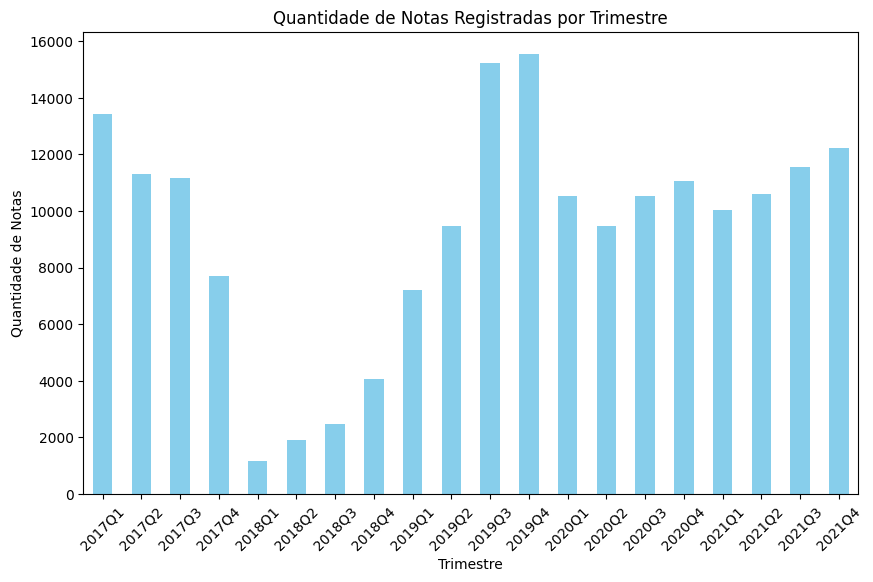

<Figure size 1000x600 with 0 Axes>

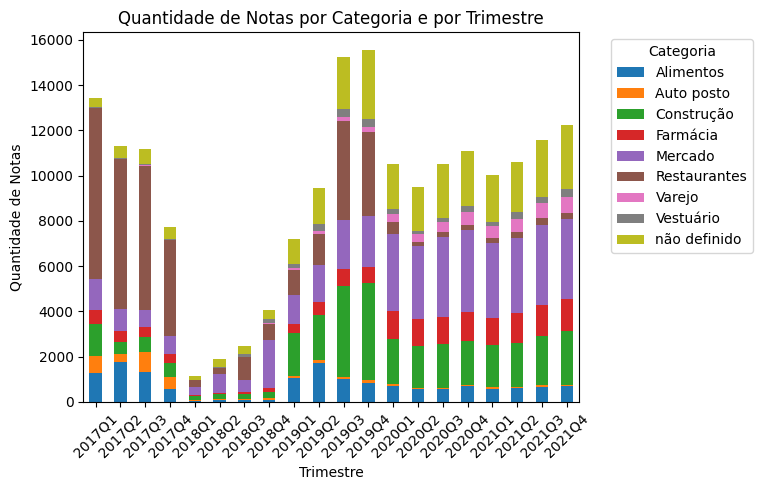

<Figure size 1000x600 with 0 Axes>

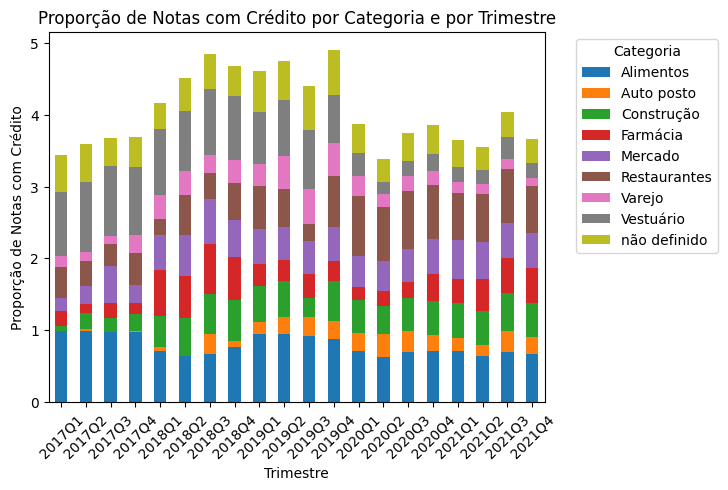

In [42]:
# Converter a coluna 'Data Emissão' para datetime (se ainda não estiver)
df['Data Emissão'] = pd.to_datetime(df['Data Emissão'])

# Definir a coluna 'trimestre' se não tiver sido definida
df['trimestre'] = df['Data Emissão'].dt.to_period('Q')  # Formato trimestral

# 1. Quantidade de notas registradas por período (trimestre)
notas_por_trimestre = df.groupby('trimestre').size()

# 2. Quantidade de notas por categoria e por período (trimestre)
notas_por_categoria_trimestre = df.groupby(['trimestre', 'categoria']).size().unstack()

# 3. Proporção de notas com crédito por categoria e por período (trimestre)
proporcao_credito_categoria_trimestre = df[df['flag_credito'] == 1].groupby(['trimestre', 'categoria']).size().unstack().fillna(0)
proporcao_credito_categoria_trimestre = proporcao_credito_categoria_trimestre.div(notas_por_categoria_trimestre, axis=0)

## Gráficos

# Gráfico 1: Quantidade de notas registradas na base por período (trimestre)
plt.figure(figsize=(10, 6))
notas_por_trimestre.plot(kind='bar', color='skyblue')
plt.title('Quantidade de Notas Registradas por Trimestre')
plt.ylabel('Quantidade de Notas')
plt.xlabel('Trimestre')
plt.xticks(rotation=45)
plt.show()

# Gráfico 2: Quantidade de notas por categoria e por período (trimestre)
plt.figure(figsize=(10, 6))
notas_por_categoria_trimestre.plot(kind='bar', stacked=True)
plt.title('Quantidade de Notas por Categoria e por Trimestre')
plt.ylabel('Quantidade de Notas')
plt.xlabel('Trimestre')
plt.xticks(rotation=45)
plt.legend(title='Categoria', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Gráfico 3: Proporção de Notas com Crédito por Categoria e por Trimestre
plt.figure(figsize=(10, 6))
proporcao_credito_categoria_trimestre.plot(kind='bar', stacked=True)
plt.title('Proporção de Notas com Crédito por Categoria e por Trimestre')
plt.ylabel('Proporção de Notas com Crédito')
plt.xlabel('Trimestre')
plt.xticks(rotation=45)
plt.legend(title='Categoria', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


## Avalie o WOE e o IV no tempo

Avalie o WOE e o IV no tempo da variável ```categoria```.

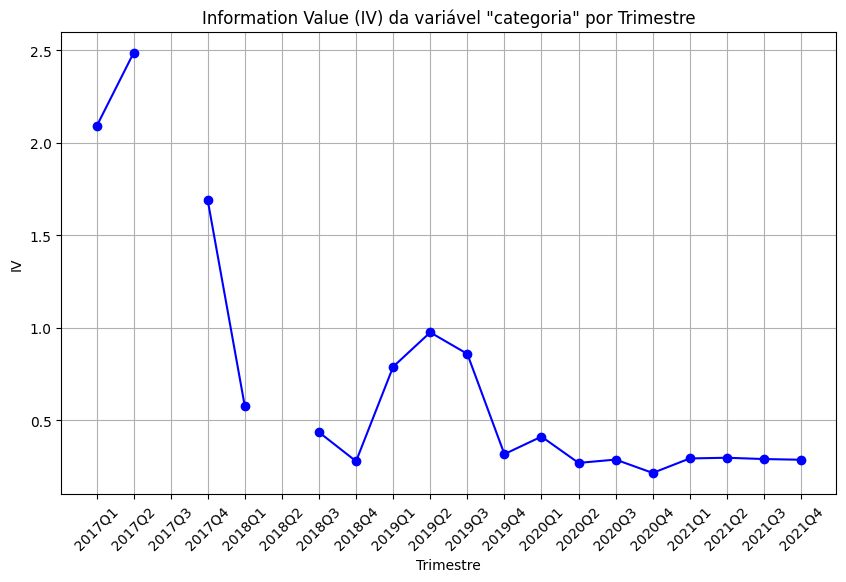

WOE do primeiro trimestre (2017Q1):
                   WOE
categoria             
Alimentos     4.742104
Auto posto   -5.486081
Construção   -2.069475
Farmácia     -0.915588
Mercado      -1.121508
Restaurantes  0.184710
Varejo       -1.274627
Vestuário     2.509562
não definido  0.485551


In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Função para calcular WOE e IV por categoria
def calcular_woe_iv(df, coluna, target):
    total_bons = df[target].sum()
    total_maus = len(df) - total_bons
    
    grupo = df.groupby(coluna).apply(lambda x: pd.Series({
        'bons': np.sum(x[target]),
        'maus': len(x) - np.sum(x[target])
    }))
    
    grupo['proporcao_bons'] = grupo['bons'] / total_bons
    grupo['proporcao_maus'] = grupo['maus'] / total_maus
    grupo['WOE'] = np.log(grupo['proporcao_bons'] / grupo['proporcao_maus'])
    grupo['IV_contrib'] = (grupo['proporcao_bons'] - grupo['proporcao_maus']) * grupo['WOE']
    
    iv = grupo['IV_contrib'].sum()
    
    return grupo[['WOE']], iv

# 1. Calculando o WOE e IV no tempo (por trimestre) para a variável 'categoria'
ivs_no_tempo = []
woes_no_tempo = {}

for trimestre, grupo in df.groupby('trimestre'):
    woe, iv = calcular_woe_iv(grupo, 'categoria', 'flag_credito')
    ivs_no_tempo.append({'trimestre': trimestre, 'IV': iv})
    woes_no_tempo[trimestre] = woe

# Converter a lista de IVs para um DataFrame para visualização
iv_df = pd.DataFrame(ivs_no_tempo)

# 2. Avaliar graficamente o IV no tempo
plt.figure(figsize=(10, 6))
plt.plot(iv_df['trimestre'].astype(str), iv_df['IV'], marker='o', color='b')
plt.title('Information Value (IV) da variável "categoria" por Trimestre')
plt.ylabel('IV')
plt.xlabel('Trimestre')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# 3. Exibir o WOE no tempo para um trimestre específico
# Acessar o primeiro trimestre corretamente
primeiro_trimestre = list(woes_no_tempo.keys())[0]  # Converte as chaves do dicionário em uma lista e pega o primeiro item
print(f"WOE do primeiro trimestre ({primeiro_trimestre}):")
print(woes_no_tempo[primeiro_trimestre])  # Exibir o WOE do primeiro trimestre


## Conclua

- Quais categorias parece ter maior proporção de notas com retornos maiores que zero?
- Essas diferenças são estáveis no tempo?

Dicas:<br>
- Considere que a quantidade de notas vem aumentando
- Considere que há períodos bem atípicos no histórico
- Considere que a partir de janeiro de 2020 o público é mais parecido com o público atual (2022), seja por pandemia, seja por crescimento do público, e considere os dados dessa data em diante na sua conclusão.

## Conclusão

### 1. Quais categorias parecem ter maior proporção de notas com retornos maiores que zero?

Analisando os valores de **WOE** do primeiro trimestre de 2017, as seguintes categorias se destacam com **WOE positivo**, o que significa que elas têm uma maior proporção de notas com retorno maior que zero:

- **Alimentos (WOE = 4.74)**: Esta categoria apresenta o maior valor de WOE, indicando que possui uma **proporção muito maior de notas com retorno** em comparação às outras categorias.
- **Vestuário (WOE = 2.51)**: Também possui um WOE alto, indicando uma alta proporção de notas com retorno.
- **Restaurantes (WOE = 0.18)** e **não definido (WOE = 0.48)**: Embora os valores sejam menores, essas categorias também indicam uma tendência positiva de gerar retornos.

Por outro lado, as categorias com **WOE negativo** indicam uma maior proporção de notas **sem retorno**:

- **Auto Posto (-5.49)**, **Construção (-2.07)**, **Farmácia (-0.91)**, **Mercado (-1.12)** e **Varejo (-1.27)**: Essas categorias têm uma maior proporção de notas que não geram créditos.

### 2. Essas diferenças são estáveis no tempo?

- Ao longo do tempo, **essas diferenças não são estáveis**. Existem **períodos atípicos** no histórico, como o período da pandemia, e o crescimento do público a partir de 2020, que podem ter impactado as proporções de notas com retorno para várias categorias.

- **A partir de janeiro de 2020**: Considerando os impactos da pandemia e o crescimento do público consumidor, os dados de 2020 em diante refletem melhor o comportamento atual. Isso sugere que as proporções de notas com retorno podem ter mudado nesse período. Por exemplo, durante a pandemia, categorias como **Alimentos** e **Mercado** podem ter aumentado as transações com retorno devido à mudança de comportamento de consumo.

- **Crescimento no número de notas**: A quantidade de notas registradas na base aumentou ao longo do tempo, o que também pode afetar o **WOE** de cada categoria. Esse aumento pode diluir ou amplificar o impacto de algumas categorias que historicamente geravam mais retornos.

### Conclusão Final:

As categorias **Alimentos** e **Vestuário** parecem ter a maior proporção de notas com retornos maiores que zero no primeiro trimestre de 2017, enquanto categorias como **Auto Posto**, **Construção** e **Farmácia** apresentam uma proporção significativamente menor de retornos. No entanto, essas diferenças **não são estáveis** ao longo do tempo. Fatores como a pandemia e o crescimento do público consumidor a partir de janeiro de 2020 podem ter alterado o comportamento das categorias. Portanto, é recomendável focar nos dados mais recentes (de 2020 em diante) para obter insights mais representativos do comportamento atual.
